<a href="https://colab.research.google.com/github/hminooei/DSbyHadi/blob/master/clickbait_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import warnings

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

The dataset is on Kaggle https://www.kaggle.com/amananandrai/clickbait-dataset however you can downloaded the file directly from the link below.

In [2]:
df = pd.read_csv("https://raw.github.com/hminooei/DSbyHadi/master/data/clickbait_data.csv.zip")
df.shape

(32000, 2)

In [3]:
pd.set_option('display.max_colwidth', 100)
df.head(3)

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer Is Here To Give You Chills",1


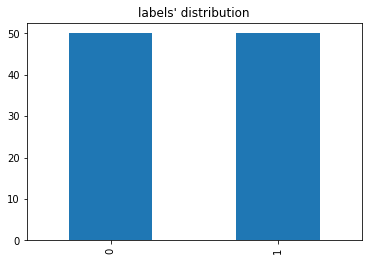

In [4]:
import matplotlib.pyplot as plt

percentages = round(df["clickbait"].value_counts()*100/len(df), 1)
percentages.plot(kind="bar", title="labels' distribution")

plt.show()

So the labels are equaly distributed.

In [0]:
text_train_val, text_test, label_train_val, label_test = train_test_split(
    df["headline"], 
    df["clickbait"], 
    test_size=0.25, 
    stratify=df["clickbait"], 
    random_state=9)

# Split the train_val dataset to train and validation separete portions.
text_train, text_val, label_train, label_val = train_test_split(
    text_train_val,
    label_train_val, 
    test_size=0.2, 
    random_state=9)

In [6]:
print(text_train.shape, text_val.shape, label_test.shape)

(19200,) (4800,) (8000,)


Read the USE pretrained network and add an output layer at the end, then, fine-tune the weights of the new network.

In [7]:
input = tf.keras.layers.Input(shape=[], dtype=tf.string)
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)(input)
output = tf.keras.layers.Dense(1, activation="sigmoid")(use)
model = tf.keras.models.Model(input, output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 256,798,337
Trainable params: 256,798,337
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

So let's fine-tune the USE weights..

In [11]:
%%time
model.fit(text_train, 
          label_train,
          epochs=1,
          validation_data=(text_val, label_val),
          verbose=2)

600/600 - 1389s - loss: 0.1001 - accuracy: 0.9740 - val_loss: 0.0471 - val_accuracy: 0.9846
CPU times: user 44min 16s, sys: 52.8 s, total: 45min 8s
Wall time: 23min 11s


In [12]:
label_preds = model.predict(text_train)
label_preds

array([[0.9936658 ],
       [0.00644249],
       [0.00768802],
       ...,
       [0.00784013],
       [0.9936316 ],
       [0.00696504]], dtype=float32)

Converting the probablities to lables.

In [13]:
label_preds_classes = np.round(label_preds)
label_preds_classes

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [14]:
train_metrics = metrics.classification_report(label_train, label_preds_classes, labels=[0, 1], digits=4)
print(train_metrics)

              precision    recall  f1-score   support

           0     0.9973    0.9963    0.9968      9627
           1     0.9962    0.9973    0.9968      9573

    accuracy                         0.9968     19200
   macro avg     0.9968    0.9968    0.9968     19200
weighted avg     0.9968    0.9968    0.9968     19200



In [15]:
label_preds_classes_test = np.round(model.predict(text_test))
test_metrics = metrics.classification_report(label_test, label_preds_classes_test, labels=[0, 1], digits=4)
print(test_metrics)

              precision    recall  f1-score   support

           0     0.9889    0.9770    0.9829      4000
           1     0.9773    0.9890    0.9831      4000

    accuracy                         0.9830      8000
   macro avg     0.9831    0.9830    0.9830      8000
weighted avg     0.9831    0.9830    0.9830      8000



As you can see, the macro precision on the test set is `0.9842`.

In [17]:
%timeit model.predict(text_test[0:1])

The slowest run took 12.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 27.6 ms per loop


In [32]:
%time model.predict(text_test[0:1])

CPU times: user 41 ms, sys: 3.05 ms, total: 44 ms
Wall time: 44.3 ms


array([[0.9930977]], dtype=float32)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Saving the model

In [37]:
tf.saved_model.save(model, "cb-use-finetune")

INFO:tensorflow:Assets written to: cb-use-finetune/assets


INFO:tensorflow:Assets written to: cb-use-finetune/assets


And later on my laptop, I can load and time it using the cells below:

In [0]:
loaded = tf.saved_model.load("/Users/hadi/Downloads/fine-tuned-use/")

In [0]:
%time loaded(text_test[0:1])